In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from ffttools import *

def subps(nrows,ncols,rowsz=3,colsz=4,axlist=False):

    f,axes = plt.subplots(nrows,ncols,figsize=(ncols*colsz,nrows*rowsz))
    if axlist and ncols*nrows == 1:
        axes = [axes]
    return f,axes

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fractional pixels).
    
    Returns the mean pixel intensity for each integer radius value bin.
    
    Adapted from: https://github.com/mkolopanis/python to also include
      the first and last bins.
    
    """
    # Calculate the indices for each pixel in the image
    y, x = np.indices(image.shape)

    if center is None: # if not user-defined, simply take the center coords of the image
        center = np.array([(y.max()-y.min())/2.0, (x.max()-x.min())/2.0])
        
    # Compute radius of each pixel in the img wrt the center of the image
    r = np.hypot(x - center[0], y - center[1]) 

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind] # all radii sorted into a 1-D array
    i_sorted = image.flat[ind] # all pixel values sorted by the radius of their position 

    # Get the integer part of the radii (i.e., radius bin size = 1)
    r_int = r_sorted.astype(int)


    # Find all pixels that fall within each radial bin.
    deltar = np.diff(r_int)  # delta radii at every consecutive position i r_int
    
    # find at which idxs in r_int the (integer) radius changes value (1s in deltar)
    rind = np.r_[np.where(deltar)[0],len(r_int)-1]+1 
    
    # number of pixels within integer radius bin
    # e.g., nr[i] contains the number of pixels with radius < (i+1)
    nr = np.diff(np.r_[0,rind])        
                                        
       
    # Cumulative sum to figure out pixel sums for each radius bin
    # first, cmpute the cumsum over all pixels sorted by radius
    csum = np.r_[0,np.cumsum(i_sorted, dtype=float)]
    
    # then, compute the differences between the last and first positions inside each radius bin
    # e.g., csum[rind[i]] contains the sum of all pixels up to the end of the i^th bin
    #    whereas csum[np.r_[0,rind[:-1]] contains the sum of all pixels that came before the i^th bin
    #   tbin[i] computes the difference between the two, which means all pixels inside the i^th bin
    tbin = csum[rind] - csum[np.r_[0,rind[:-1]]] #this computes the above for all values of i
    
    radial_prof = tbin / nr # dividing by the number of pixels in each bin computes the mean radial profile

    return radial_prof

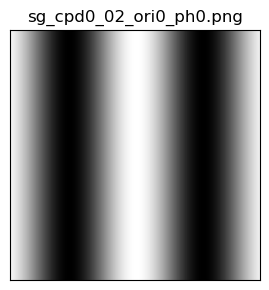

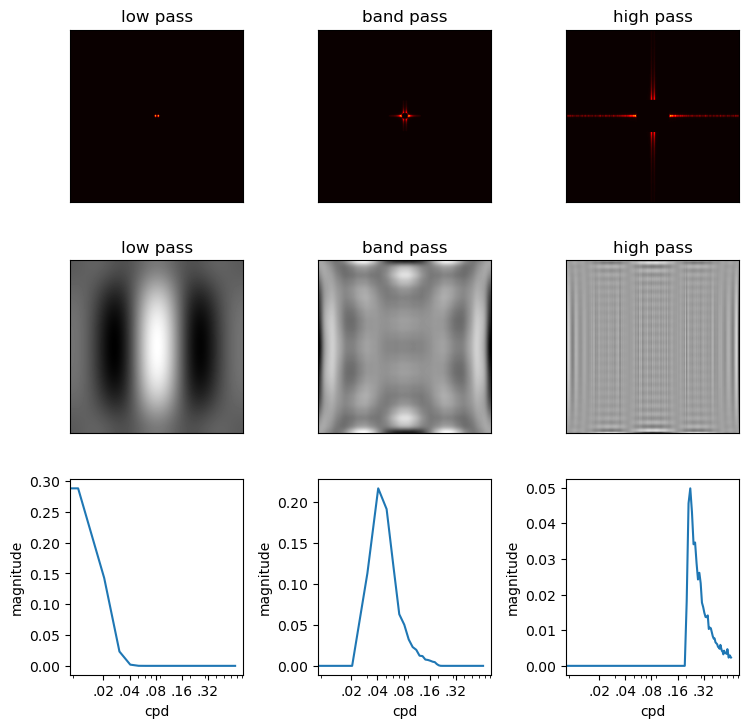

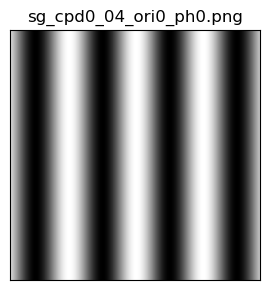

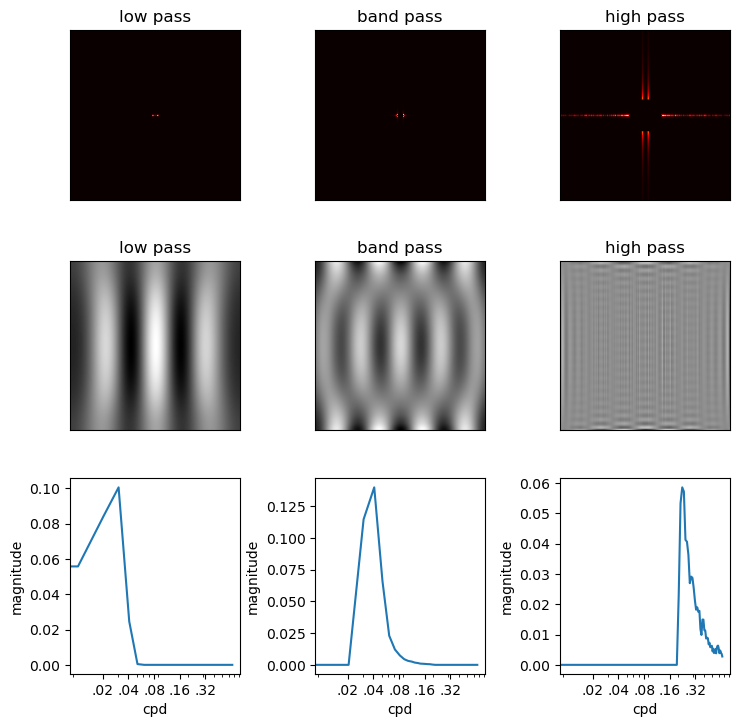

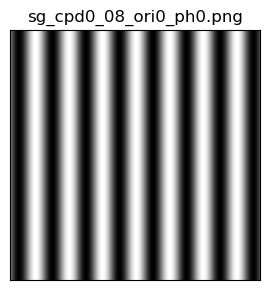

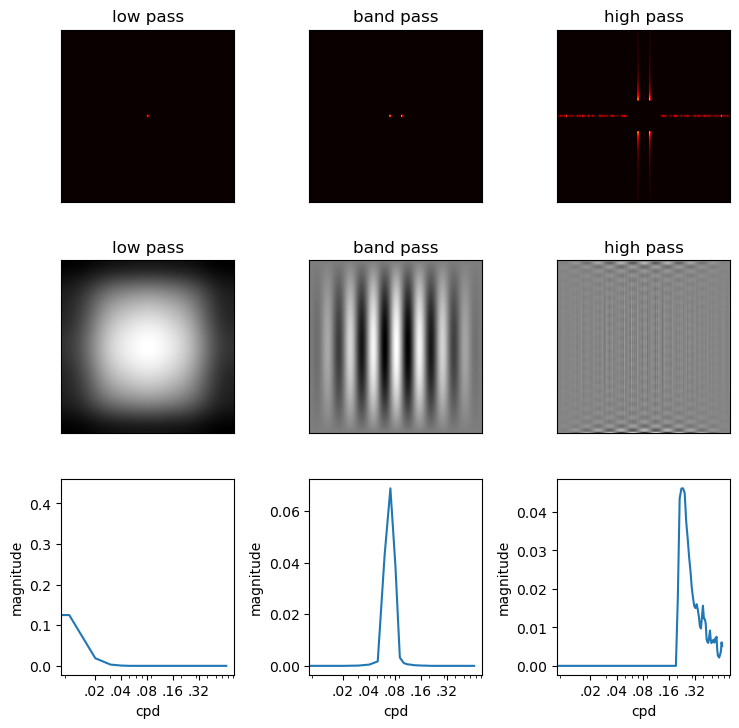

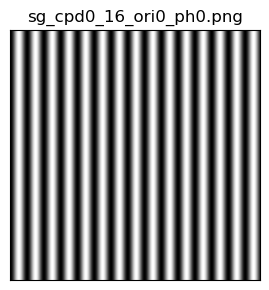

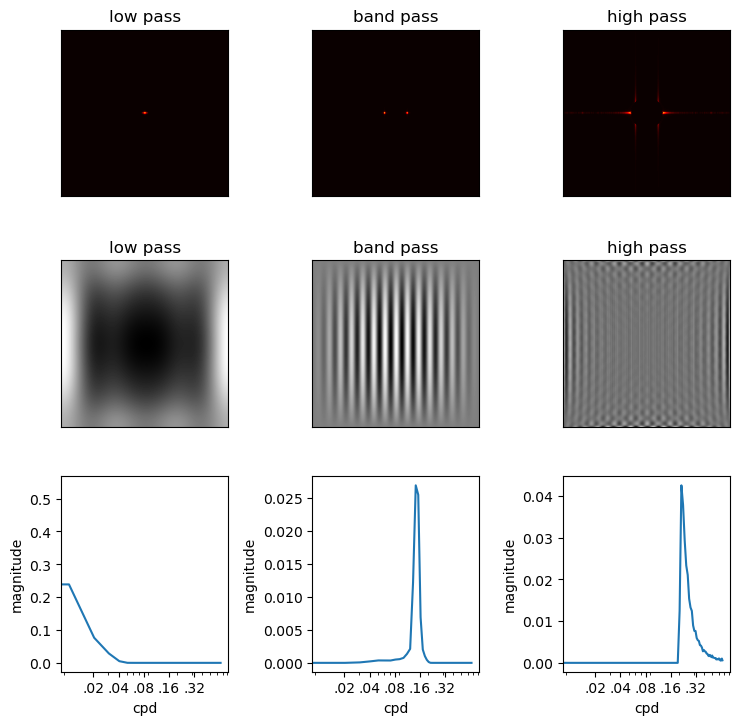

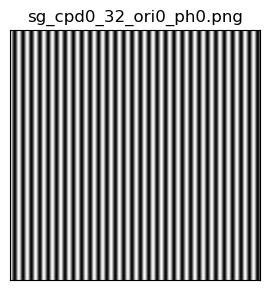

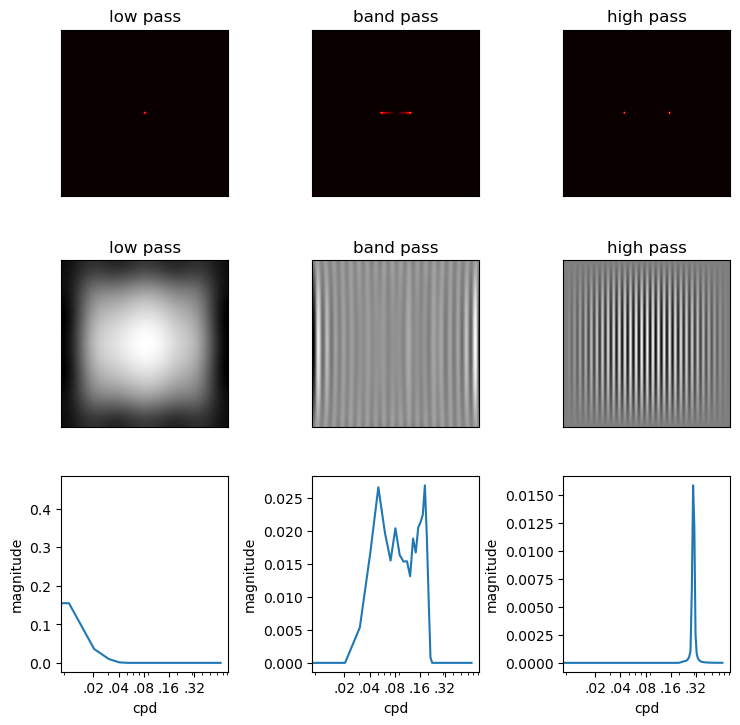

In [3]:
# Check that the 3 filters work as they should for gratings at various SFs
# This is used to ensure that the mask parameters below work as expected
lo, hi, pad = 4, 22, 1

# lomask = Mask(ps.data)
# lomask.create_circle_mask(lo,pad)
# himask = Mask(ps.data)
# himask.create_circle_mask(hi,pad,high_pass=True)
# bandmask = Mask(ps.data)
# bandmask.bandpass(lo+pad,pad,hi-pad,pad)
px_per_deg = 918/98
side_to_use = 918
freqs = px_per_deg/side_to_use*np.arange(side_to_use)


mypicnames = ['statgrats/sg_cpd0_02_ori0_ph0.png',
              'statgrats/sg_cpd0_04_ori0_ph0.png',
             'statgrats/sg_cpd0_08_ori0_ph0.png',
             'statgrats/sg_cpd0_16_ori0_ph0.png',
             'statgrats/sg_cpd0_32_ori0_ph0.png']
for mypicname in mypicnames:
    mypic = MyImage()
    mypic.read_from_file(mypicname)
    mypic.squareit()
    #mypic.convert2grayscale()
#     mypic.binning(0)
    mypic.normalize()
    
    lomask = Mask(mypic.data)
    lomask.create_circle_mask(lo,pad)
    himask = Mask(mypic.data)
    himask.create_circle_mask(hi,pad,high_pass=True)
    bandmask = Mask(mypic.data)
    bandmask.bandpass(lo+pad,pad,hi-pad,pad) 
    
    
    f, ax = subps(1,1)
    mypic.show_image(ax=ax)
    ax.set(title=mypicname.split('/')[-1], xticks=[], yticks=[])
    f.tight_layout()
    plt.show()

    f, axes = subps(3,3, 2.5, 2.5)
    for i, (mask, name) in enumerate([(lomask,'low pass'), (bandmask,'band pass'), (himask,'high pass')]):
        ft = ImgFFT(mypic, mask=mask)
        ps = ft.get_magnitude()
        ax = axes[0,i]
        ps.show_image('hot',ax=ax, center_crop=hi*5)
        ax.set(title=name, xticks=[], yticks=[])

        ax = axes[1,i]
        ft.imgifft.show_image(ax=ax)

        ax.set(title=name, xticks=[], yticks=[])

        psd1D = azimuthalAverage(ps.data)
        ax = axes[2,i]
        ax.plot(freqs[:hi*3],psd1D[:hi*3])
        ax.set(xlabel='cpd',ylabel='magnitude', xscale='log', xticks=[.02,.04,.08,.16,.32],
               xticklabels=['.02','.04','.08','.16','.32'])
    f.tight_layout()
    plt.show()

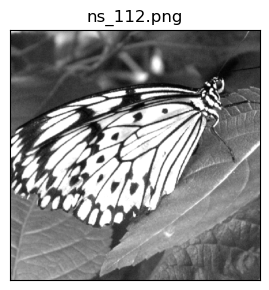

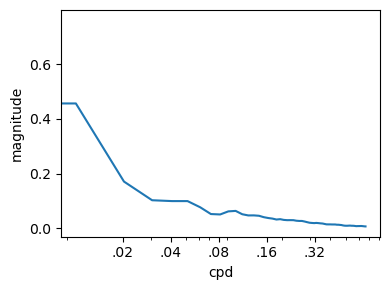

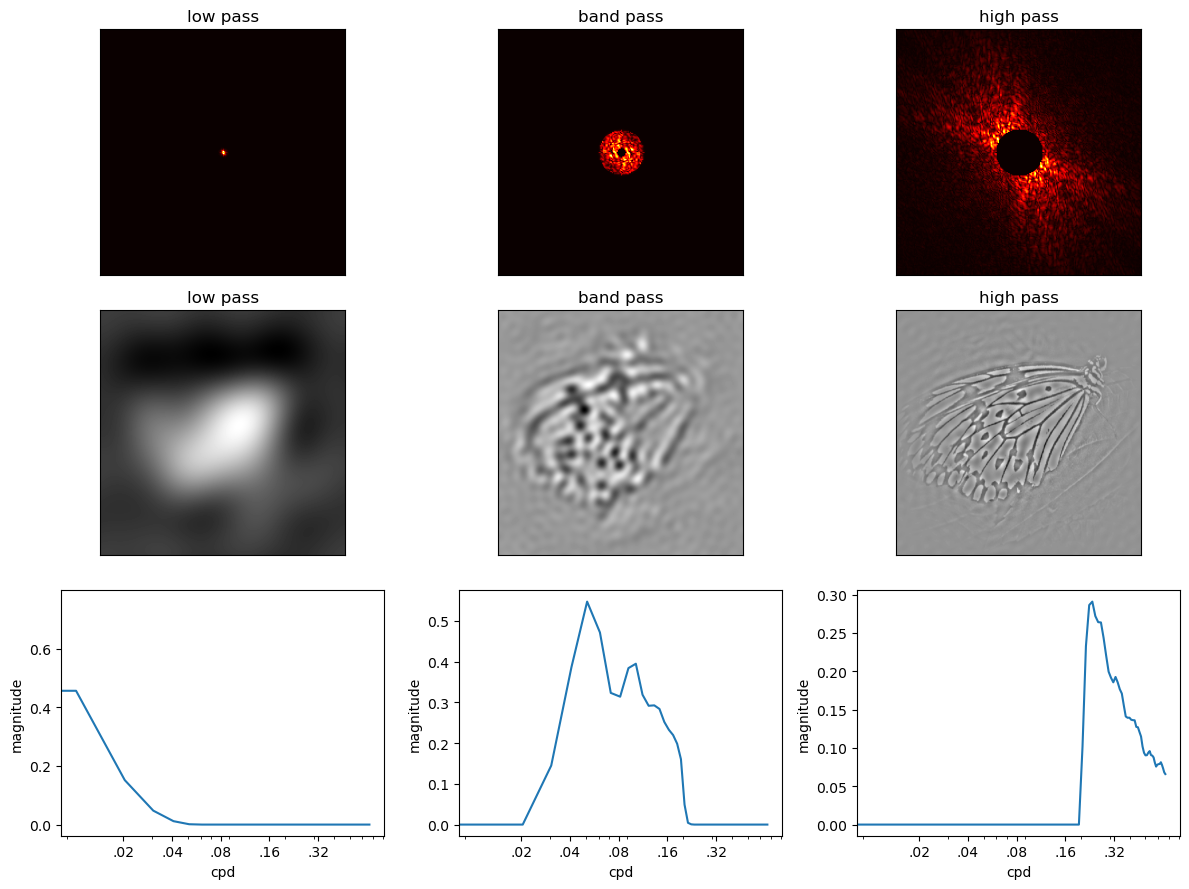

In [4]:
lo, hi, pad = 4, 22, 1

px_per_deg = 918/98
side_to_use = 918
freqs = px_per_deg/side_to_use*np.arange(side_to_use)


ns_fnames = ['natscenes/ns_%03d.png' % i for i in [112]]

for mypicname in ns_fnames:
    mypic = MyImage()
    mypic.read_from_file(mypicname)
    mypic.squareit()
    #mypic.convert2grayscale()
    #mypic.binning(0)
    mypic.normalize()
    
    lomask = Mask(mypic.data)
    lomask.create_circle_mask(lo,pad)
    himask = Mask(mypic.data)
    himask.create_circle_mask(hi,pad,high_pass=True)
    bandmask = Mask(mypic.data)
    bandmask.bandpass(lo+pad,pad,hi-pad,pad) 
    
    f, ax = subps(1,1)
    mypic.show_image(ax=ax)
    ax.set(title=mypicname.split('/')[-1], xticks=[], yticks=[])
    f.tight_layout()
    plt.show()
    
    f, ax = subps(1,1)
    ft = ImgFFT(mypic)
    ft.ft()
    ps = ft.get_magnitude()
    psd1D = azimuthalAverage(ps.data)
    ax.plot(freqs[:hi*3],psd1D[:hi*3])
    ax.set(xlabel='cpd',ylabel='magnitude', xscale='log', xticks=[.02,.04,.08,.16,.32],
               xticklabels=['.02','.04','.08','.16','.32'])
    f.tight_layout()
#     plt.savefig('output/ns%03d_spectrum.pdf' % imi,transparent=True, bbox_inches='tight')
    plt.show()

    f, axes = subps(3,3)
    for i, (mask, name) in enumerate([(lomask,'low pass'), (bandmask,'band pass'), (himask,'high pass')]):
        ft = ImgFFT(mypic, mask=mask)
        ps = ft.get_magnitude()
        ax = axes[0,i]
        ps.show_image('hot',ax=ax, center_crop=hi*5)
        ax.set(title=name, xticks=[], yticks=[])

        ax = axes[1,i]
        ft.imgifft.show_image(ax=ax)

        ax.set(title=name, xticks=[], yticks=[])

        psd1D = azimuthalAverage(ps.data)
        ax = axes[2,i]
        ax.plot(freqs[:hi*3],psd1D[:hi*3])
        ax.set(xlabel='cpd',ylabel='magnitude', xscale='log', xticks=[.02,.04,.08,.16,.32],
               xticklabels=['.02','.04','.08','.16','.32'])
    f.tight_layout()
#     plt.savefig('output/ns%03d_full.pdf' % imi,transparent=True, bbox_inches='tight')
    plt.show()